# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile

from PIL import Image
import pytesseract

from kraken import pageseg
import cv2 as cv
import numpy as np

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!
import string
import math
import os

minLineLength = 100
maxLineGap = 50

class Page:
    def __init__(self, name):
        self.name = name
        self.im = Image.open(name)
        self.gray = cv.cvtColor(cv.imread(name), cv.COLOR_BGR2GRAY) # convert2grayscale
        self.words = self.__build_text()
        self.faces = self.__detect_faces()
    
    def __str__(self):
        return self.name
    
    def find(self, name):
        return name.lower() in self.words
    
    def diplay(self, n=5, size=128):
        # Make our canvas, and we'll make it n times the size of the thumbnail
        contact_sheet=Image.new(self.faces[0].mode, (size * n, size * math.ceil(len(self.faces)/n)))
        x, y = 0, 0
        for img in self.faces:
            img.thumbnail((size, size))
            # Lets paste the current image into the contact sheet
            contact_sheet.paste(img, (x, y) )
            # Now we update our X position. If it is going to be the width of the image, then we set it to 0
            # and update Y as well to point to the next "line" of the contact sheet.
            x, y = (0, y+size) if x+size == contact_sheet.width else (x+size, y)
        # Now lets display that composite image
        display(contact_sheet)
    
    def __lines_extraction(self, gray: list) -> list:
        """
        this function extracts the lines from the binary image. Cleaning process.
        """
        edges = cv.Canny(gray, 75, 150)
        lines = cv.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength, maxLineGap)
        return lines
    
    def __clean(self):
        (contours, _) = cv.findContours(~self.gray,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
        # create blank image of same dimension of the original image
        mask = np.ones(self.gray.shape, dtype="uint8") * 255
        self.img_contours = []
        areas = [cv.contourArea(c) for c in contours] # find area of contour
        avgArea = sum(areas)/len(areas) # finding average area
        for c in contours:# average area heuristics
            if cv.contourArea(c)>60*avgArea:
                # Remove pictures from image as contours with largest area
                cv.drawContours(mask, [c], -1, 0, -1)
                self.img_contours.append(c)

        lines = self.__lines_extraction(self.gray) # extract lines
        try:
            for line in lines: # write lines to mask
                x1, y1, x2, y2 = line[0]
                cv.line(mask, (x1, y1), (x2, y2), (0, 255, 0), 3)
        except TypeError:
            pass

        return ~cv.bitwise_and(~self.gray, ~self.gray, mask=mask) # subtracting the noise
     
    def __build_text(self):
        _, binary = cv.threshold(self.__clean(), 150, 255, cv.THRESH_BINARY) # convert2binary
        return pytesseract.image_to_string(binary).lower()
    
    def __detect_faces(self, scale=1.2):
        # lets try and detect faces in that image
        face_list = []
        for contour in self.img_contours:
            [x, y, w, h] = cv.boundingRect(contour)
            seg_img = self.im.crop((x, y, x+w, y+h))
            faces = face_cascade.detectMultiScale(self.gray[y: y+h, x: x+w],scale)
            for x,y,w,h in faces:
                face = seg_img.crop((x, y, x+w, y+h))
                face_list.append(face)
        return face_list

### Search for "Chris" in the small images

Results found in file a-0.png


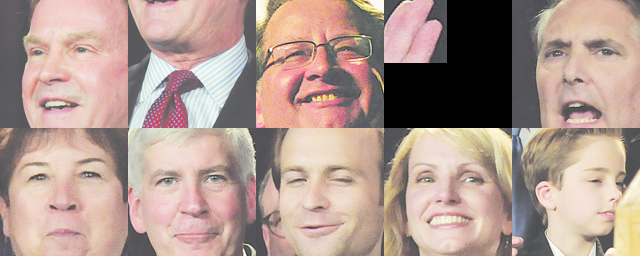

Results found in file a-3.png


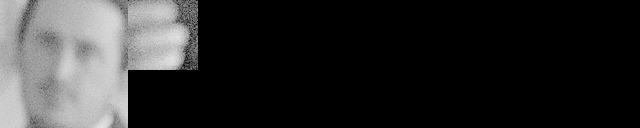

In [2]:
with zipfile.ZipFile('readonly/small_img.zip') as myzip:
    for f in myzip.infolist():
        myzip.extract(f.filename)
        page = Page(f.filename)
        os.remove(f.filename)
        if page.find("Chris"):
            print("Results found in file", page)
            if page.faces:
                page.diplay()
            else:
                print("But there were no faces in that file!")

### Search for "Mark" in the large images

Results found in file a-0.png


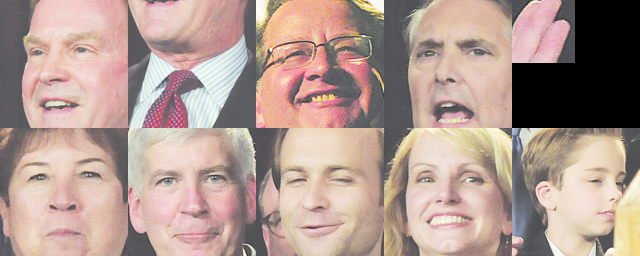

Results found in file a-1.png


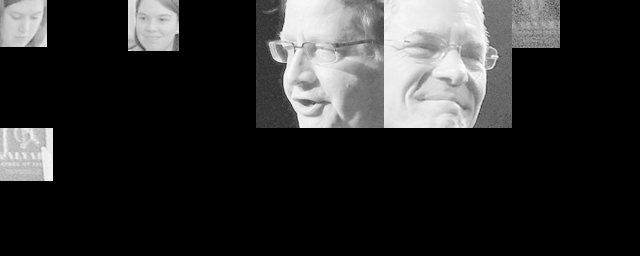

Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png


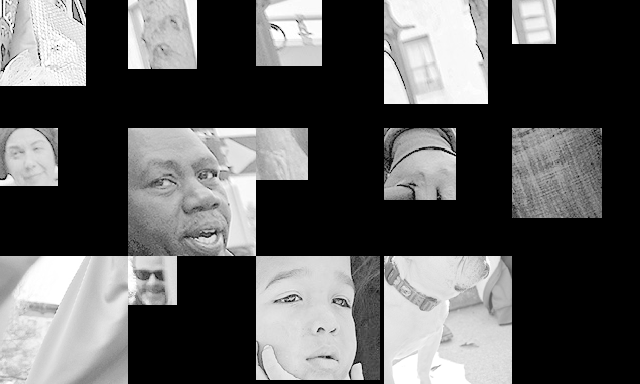

Results found in file a-2.png


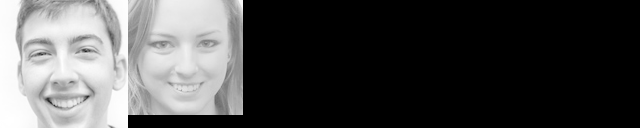

Results found in file a-3.png


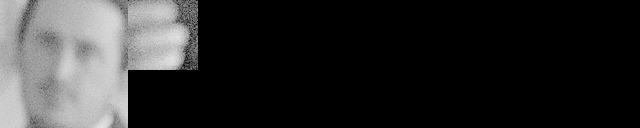

Results found in file a-5.png


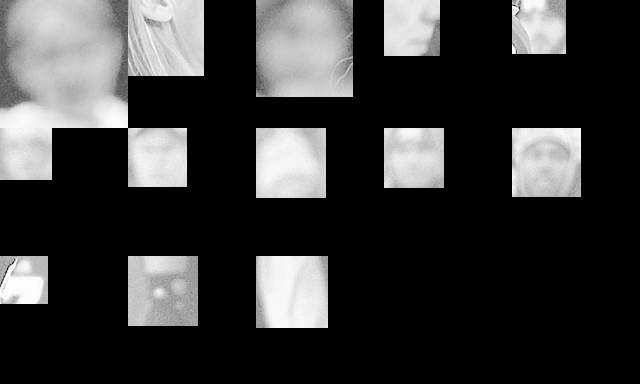

Results found in file a-8.png


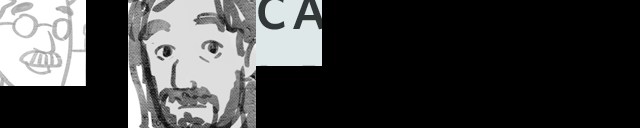

In [3]:
with zipfile.ZipFile('readonly/images.zip') as myzip:
    for f in myzip.infolist():
        myzip.extract(f.filename)
        page = Page(f.filename)
        os.remove(f.filename)
        if page.find("Mark"):
            print("Results found in file", page)
            if page.faces:
                page.diplay()
            else:
                print("But there were no faces in that file!")

The intermediate building procedures and the principles please see the file [project-procedures.ipynb](./project-procedures.ipynb).